In [2]:
import os

# Check current working directory
print(os.getcwd())

# Change to the root directory of your project, if necessary
os.chdir('C:/Users/yashv/Downloads/HADLN_implementation/HADLN_implementation/')
print(os.getcwd())


c:\Users\yashv\Downloads\HADLN_implementation\HADLN_implementation\notebooks
C:\Users\yashv\Downloads\HADLN_implementation\HADLN_implementation


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
csv_file_path = 'C:/Users/yashv/Downloads/HADLN_implementation/HADLN_implementation/data/raw/physionet2017.csv'
data = pd.read_csv(csv_file_path)

# Preprocessing
# Assuming the last column is the label and second last is something else we ignore for now
ecg_signals = data.iloc[:, :-2].values.reshape(-1, 2000, 1)  # Adjust the slicing based on your dataset
labels = data.iloc[:, -1].values  # Assuming the last column is the label

# Scale data
scaler = StandardScaler()
ecg_signals_scaled = scaler.fit_transform(ecg_signals.reshape(-1, 2000)).reshape(-1, 2000, 1)

# Convert labels to one-hot encoding
num_classes = np.unique(labels).size  # Determine the number of unique labels
labels_one_hot = to_categorical(labels, num_classes=num_classes)

# Split data into 50% training and 50% testing
X_train, X_test, y_train, y_test = train_test_split(ecg_signals_scaled, labels_one_hot, test_size=0.5, random_state=42)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training data shape: (4264, 2000, 1), Training labels shape: (4264, 4)
Testing data shape: (4264, 2000, 1), Testing labels shape: (4264, 4)


In [4]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Specify the path to the model
model_path = 'resnet_dwt_best_model.h5'  # Adjust path if necessary

# Load the trained model without specifying the loss function
model = tf.keras.models.load_model(model_path)

# Recompile the model with Sparse Categorical Crossentropy loss function
model.compile(optimizer=Adam(learning_rate=1e-4),  # Adjust learning rate if necessary
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Summary of the loaded model to ensure it has been loaded and compiled correctly
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RR_Interval_Input (InputLayer)  [(None, 19)]        0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 128)          2560        ['RR_Interval_Input[0][0]']      
                                                                                                  
 reshape_5 (Reshape)            (None, 1, 128)       0           ['dense_12[0][0]']               
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 1, 128)      263808      ['reshape_5[0][0]',              
 eadAttention)                                                    'reshape_5[0][0]']        

In [5]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


ValueError: in user code:

    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\yashv\.conda\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_5" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2000, 1) dtype=float32>]


134/134 [==============================] - 7s 42ms/step


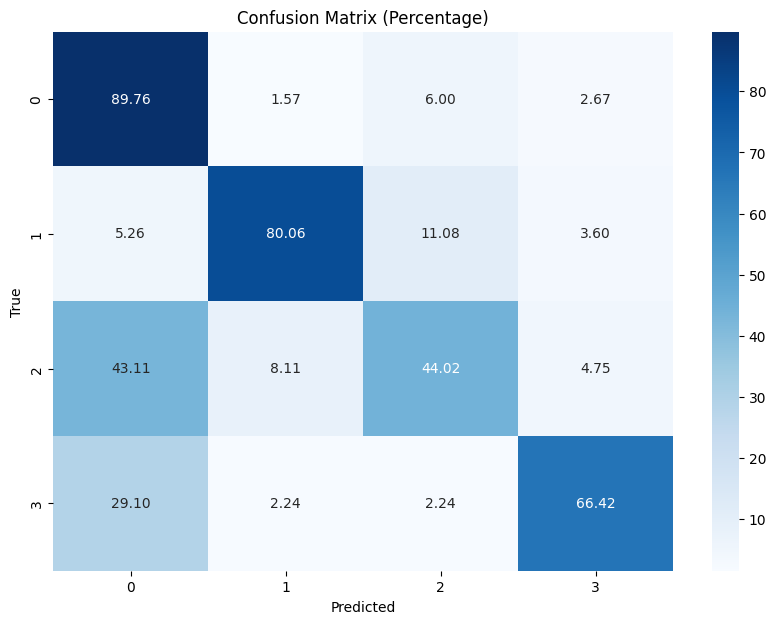

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      2549
           1       0.67      0.80      0.73       361
           2       0.73      0.44      0.55      1220
           3       0.39      0.66      0.49       134

    accuracy                           0.75      4264
   macro avg       0.65      0.70      0.65      4264
weighted avg       0.75      0.75      0.74      4264



In [5]:
# Convert y_test from one-hot encoding to class labels if necessary
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # If y_test is already in class label format

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix using the class labels
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))
